In [1]:
import glob
import imageio
import PIL
import os
import tqdm
import time

import numpy as np
import cv2 as cv
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from sklearn.utils import shuffle
from IPython import display
from datetime import datetime
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
os.chdir('/content/gdrive/My Drive/Momothesis')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
def preprocess_images(images):
  height = images.shape[1]
  width = images.shape[2]
  images = images.reshape((images.shape[0], height, width, 3)) / 255.  
  return images.astype('float32')

In [3]:
def generate_train_test(array, train_size = 0.8):
  array = np.random.permutation(array)

  train_size = int(len(array) * 0.8)
  test_size = len(array) - train_size

  x_train = array[:train_size]
  x_test = array[train_size:]

  train_images = x_train.astype('float32') / 255
  test_images = x_test.astype('float32') / 255

  return train_images, test_images

In [4]:
scans20 = np.load('data/mitos_atypia/arrays/scans_split_x20_resized.npy')

In [5]:
##GAN SIMPLE##
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)

noise_dim = 100
batch_size = 16
epochs = 30
steps_per_epoch = 3750
img_rows, img_cols, channels = 96, 96, 3

optimizer = Adam(0.0002, 0.5)

In [6]:
train, test = generate_train_test(scans20)
x_train = train.reshape(-1, img_rows*img_cols*channels)

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [8]:
def create_discriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [9]:
discriminator = create_discriminator()
generator = create_generator()

In [10]:
from keras.layers import Input
from keras.models import Model

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [11]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator()
generator = create_generator()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [12]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
fake_x = generator.predict(noise)

In [13]:
real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

In [14]:
x = np.concatenate((real_x, fake_x))

In [15]:
disc_y = np.zeros(2*batch_size)
disc_y[:batch_size] = 0.9

In [23]:
d_loss = discriminator.train_on_batch(x, disc_y)
d_loss

0.686397910118103

In [ ]:
y_gen = np.ones(batch_size)
g_loss = gan.train_on_batch(noise, y_gen)

In [18]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')

Epoch: 0 	 Discriminator Loss: 0.6822824478149414 		 Generator Loss: 0.8024463653564453
Epoch: 1 	 Discriminator Loss: 0.7125079035758972 		 Generator Loss: 1.0771621465682983
Epoch: 2 	 Discriminator Loss: 0.6929457187652588 		 Generator Loss: 0.7638823390007019
Epoch: 3 	 Discriminator Loss: 0.6893946528434753 		 Generator Loss: 0.7491530776023865
Epoch: 4 	 Discriminator Loss: 0.6664110422134399 		 Generator Loss: 0.5634945631027222
Epoch: 5 	 Discriminator Loss: 0.7000223398208618 		 Generator Loss: 0.7413771152496338
Epoch: 6 	 Discriminator Loss: 0.6940094828605652 		 Generator Loss: 0.7839707136154175
Epoch: 7 	 Discriminator Loss: 0.6685612201690674 		 Generator Loss: 0.8365848660469055
Epoch: 8 	 Discriminator Loss: 0.6852367520332336 		 Generator Loss: 0.7794753313064575
Epoch: 9 	 Discriminator Loss: 0.7020081877708435 		 Generator Loss: 0.8785433769226074
Epoch: 10 	 Discriminator Loss: 0.6902681589126587 		 Generator Loss: 0.8179820775985718
Epoch: 11 	 Discriminator Loss:

In [19]:
import matplotlib.pyplot as plt

def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

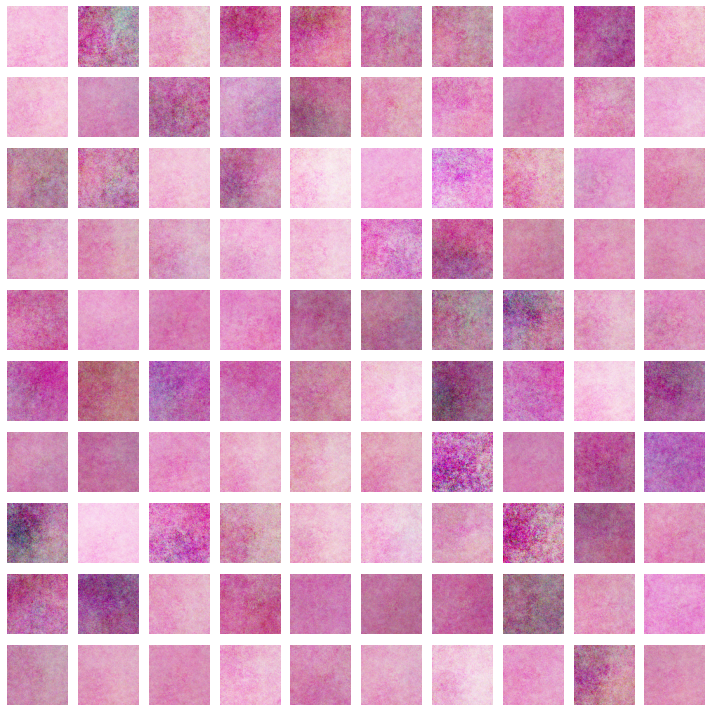

In [20]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)